To make a meaningful comparison I think I need to know more about my source behaviour. However I can still get a point spread function

In [45]:
from ParticleTracerClass import ParticleTracer
from phaseSpaceAnalyzer import SwarmSnapShot
import dill
from tqdm import tqdm
import time
from SwarmTracerClass import SwarmTracer
import warnings
import numpy as np
from ParticleClass import Swarm,Particle
from ParticleClass import Particle as ParticleBase
from ParticleTracerLatticeClass import ParticleTracerLattice
import matplotlib.pyplot as plt

LObject=72.0E-2
LImage=85E-2
LLensHardEdge=15.24e-2
rpLens=(5e-2,5e-2 +2.54e-2)
magnetWidth=(.0254,.0254*1.5)

fringeFrac=1.5
LFringe=fringeFrac*max(rpLens)
LLens=LLensHardEdge+2*LFringe
LObject-=LFringe
LImage-=LFringe

PTL=ParticleTracerLattice(v0Nominal=210.0,latticeType='injector',parallel=True)
PTL.add_Drift(LObject+0*2*rpLens[0],ap=.07)
PTL.add_Halbach_Lens_Sim(rpLens,LLens,apFrac=.98,magnetWidth=magnetWidth)
# PTL.add_Lens_Ideal(LLens-4*rpLens[0],1.0,rpLens[0])
PTL.add_Drift(LImage*2+0*2*rpLens[0],ap=.07)
# assert PTL.elList[1].fringeFracOuter==fringeFrac and abs(PTL.elList[1].Lm-LLensHardEdge)<1e-9
PTL.end_Lattice()

xMin=abs(PTL.elList[-1].r1[0])
xMax=abs(PTL.elList[-1].r2[0])


# Helper functions

In [46]:

class Interpolater:
    def __init__(self,swarm,PTL):
        self.swarm=swarm
        self.PTL=PTL
        self.endDriftLength=abs(self.PTL.elList[-1].r2[0]-self.PTL.elList[-1].r1[0])
    def __call__(self,xOrbit,maxRadius=np.inf,vTMax=np.inf,returnP=False,useAssert=True,useInitial=False):
        #xOrbit: Distance in orbit frame, POSITIVE to ease with analyze. Know that the tracing is done with x being negative
        #returns in units of mm
        #vTMax: maximum transverse velocity for interpolation
        #useAssert: I can use this interplater elsewhere if I turn this off
        if useAssert==True:
            assert -self.PTL.elList[-1].r2[0]>xOrbit>-self.PTL.elList[-1].r1[0]
        yList=[]
        zList=[]
        pList=[]
        for particle in self.swarm.particles:
            if useInitial==True:
                p,q=particle.pi,particle.qi
            else:
                p,q=particle.pf,particle.qf
            vT=np.sqrt(p[1]**2+p[2]**2)
            if (q[0]<-xOrbit and vT<vTMax) or useInitial==True:
                stepFrac=(abs(q[0])-xOrbit)/self.endDriftLength
                ySlope=p[1]/p[0]
                y=q[1]+stepFrac*self.endDriftLength*ySlope
                zSlope=p[2]/p[0]
                z=q[2]+stepFrac*self.endDriftLength*zSlope
                yList.append(y)
                zList.append(z)
                pList.append(p)
        yArr=np.asarray(yList)*1e3
        zArr=np.asarray(zList)*1e3
        rArr=np.sqrt(yArr**2+zArr**2)
        yArr=yArr[rArr<maxRadius]
        zArr=zArr[rArr<maxRadius]
        pArr=np.asarray(pList)[rArr<maxRadius]
        returnArgs=[yArr,zArr]
        if returnP==True:
            returnArgs.append(pArr)
        return returnArgs


# Load simulated particles, with final position and velocity, assuming they havne't been clipped for skimmer survival

In [47]:
#load and flip longitudinal velocity
import pandas as pd
simEndName='run57_z9_cm.txt'
simEndX=9e-2
filePath='particlesAtDifferentStops/'
fileName=filePath+simEndName
data = np.asarray(pd.read_csv(fileName, delim_whitespace=True, header=None))
# np.random.shuffle(data) #only shuffles along first axis
assert data.shape[1]==6
print('number of particles:', len(data))
data[:,:2]*=-1
data[:,3:5]*=-1
np.random.shuffle(data)
vHeTerminal=210
assert np.sum(np.isnan(data))==False

number of particles: 3091006


In [48]:
#only add particles that pass through the skimmer
import multiprocess as mp
import numba
xSkimmer=-16e-2
DSkimmer=2.54E-2
onlyThermalized=True
vCutoff=10.0
@numba.njit()
def is_Initial_Pos_Valid(qi):
    #some particles can make it through the skimmer, but startred in some weird spot
    eps=1e-3
    if qi[0]-simEndX>eps:
        return False
    else: return True
@numba.njit()
def is_Particle_Valid(qi,pi):
    dt=(xSkimmer-qi[0])/pi[0]
    qAtSkimmer=qi+pi*dt
    r=np.linalg.norm(qAtSkimmer[1:]) #get radius using y and z
    if (abs(pi[0])-vHeTerminal)>vCutoff and onlyThermalized==True:
        return False
    if r<DSkimmer/2 and is_Initial_Pos_Valid(qi):
        assert dt>0.0
        return True
    else:
        return False
swarmInitial=Swarm()
qiList=[]
piList=[]
for Xi in data:
    qi=Xi[:3]
    pi=Xi[3:]
    if is_Particle_Valid(qi,pi)==True:
        qiList.append(qi)
        piList.append(pi)
        swarmInitial.add_Particle(qi=qi,pi=pi)
print(swarmInitial.num_Particles())
piArr=np.asarray(piList)
qiArr=np.asarray(qiList)
assert np.std(piArr[:,0])<5.0 #reasonable spread on longitudinal velocities
assert abs(np.mean(piArr[:,0]))-vHeTerminal<1.0 #should be close to terminal
# assert abs(np.min(data[:,0])-simEndX)<1e-3 #last x position should be small difference from simulation bounds
print('efficiency: ',1e2*swarmInitial.num_Particles()/len(data))
# plt.hist(piArr[:,0],bins=100)
# plt.show()

25820
efficiency:  0.8353267512259762


# Trace Swarm

In [49]:
# #make a fake swarm for testing only
# swarmTracer=SwarmTracer(PTL)
# particleTracer=ParticleTracer(PTL)
# numParticles=100_000
# h=5e-6
# v0=210.0
# sourceAngle=.08
# swarmInitial=swarmTracer.initalize_PseudoRandom_Swarm_In_Phase_Space(1e-9,sourceAngle*v0,1e-9,numParticles,circular=True)

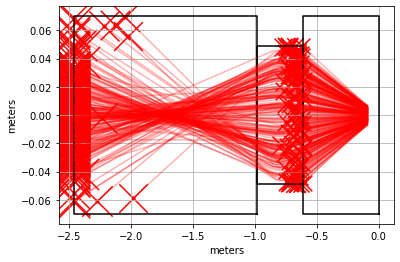

In [50]:
#visually inspect the result of tracing with a small number of particles
%matplotlib inline
swarmTracer=SwarmTracer(PTL)
swarmSmall=Swarm()
swarmSmall.particles=swarmInitial.particles[:300]
h=1e-5 #time step, s
T=1.0 #s, sufficient for linear tracing through lens
fastMode=False

swarmTraced=swarmTracer.trace_Swarm_Through_Lattice(swarmSmall,h,1.0,fastMode=fastMode,copySwarm=True,parallel=True,stepsBetweenLogging=4)
PTL.show_Lattice(swarm=swarmTraced,showTraceLines=True,trueAspectRatio=False,traceLineAlpha=.3)

In [51]:
#trace swarm and interpolate
swarmTracer=SwarmTracer(PTL)
h=5e-6 #time step, s
T=1.0 #s, sufficient for linear tracing through lens
fastMode=True
t=time.time()
swarmTraced=swarmTracer.trace_Swarm_Through_Lattice(swarmInitial,h,1.0,fastMode=fastMode,copySwarm=True,parallel=True)
print('time to run,s :',time.time()-t) #23
#count how many particle survived roughly
xEnd=PTL.elList[-1].r2[0]

interpFunction=Interpolater(swarmTraced,PTL)
# PTL.show_Lattice(swarm=swarmTraced,showTraceLines=True,trueAspectRatio=False)
swarmTraced.num_Particles()

time to run,s : 61.4734890460968


25820

In [52]:
#function that used interpolation to get simulated flourescence signal
def get_Floursence_Signal(x,binNum=100,maxRadius=np.inf,vTMax=np.inf):
  #given an x, return the signal that we would collect with a laser. Sensitive to binNum
  yArr,zArr=interpFunction(x,maxRadius=maxRadius,vTMax=vTMax)
  rArr=np.sqrt(yArr**2+zArr**2)

  signal,bins=np.histogram(rArr,bins=binNum)
  binSize=bins[1]-bins[0]
  rBinArr=bins[:-1]+binSize/2
  radiusWeight=1/(rBinArr*binSize*2*np.pi)
  signal=signal*radiusWeight
  return rBinArr,signal

## Analyze by flux in a circle of set diameter

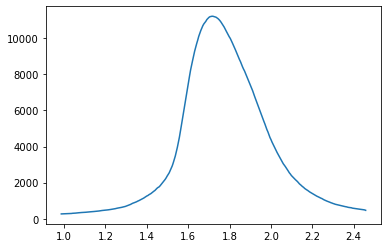

(1.716880198019802, 11217)

In [53]:
#don't attempt this on huge numbers of particles. Use a smaller number here like 100,000
from joblib import Parallel,delayed
import multiprocess
import scipy.interpolate as spi

#find circle of least confusion location
swarmTestMin=Swarm()
swarmTestMin.particles=swarmTraced.particles[:100_000]
interpFunctionMin=Interpolater(swarmTestMin,PTL)
xArr=np.linspace(xMin+1e-3,xMax-1e-3,300)
vTMax=20.0 #only include particles with this maximum transverse speed

def atomsInCircle(x,maxRadius=5):
  xCoords,yCoords=interpFunctionMin(x,maxRadius=maxRadius,vTMax=vTMax)
  r=np.sqrt(xCoords**2+yCoords**2)
  numParticles=len(r)
  return numParticles

multiprocess.set_start_method('fork',force=True)
t=time.time()
with multiprocess.Pool(10) as pool:
    fluxArr=np.asarray(pool.map(atomsInCircle,xArr))
interpFunc=spi.RBFInterpolator(xArr[:,np.newaxis],fluxArr)
  

xArrDense=np.linspace(xArr[0],xArr[-1],10000)
yArrDense=interpFunc(xArrDense[:,np.newaxis])

xMaxSig=xArrDense[np.argmax(yArrDense)]



plt.plot(xArr,fluxArr)
# plt.plot(xArrDense,yArrDense,c='r')
plt.show()
xMaxSig,np.max(fluxArr) #(1.716880198019802, 11217)

# Analyze by circle of least confusion

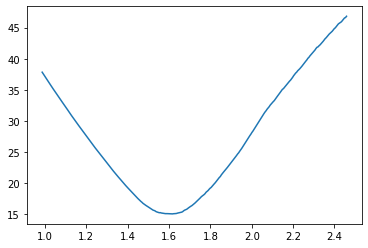

15.057655131422612

In [54]:
#don't attempt this on huge numbers of particles. Use a smaller number here like 100,000
from joblib import Parallel,delayed
import multiprocess
import scipy.interpolate as spi

#find circle of least confusion location
swarmTestMin=Swarm()
swarmTestMin.particles=swarmTraced.particles[:100_000]
interpFunctionMin=Interpolater(swarmTestMin,PTL)
xArr=np.linspace(xMin+1e-3,xMax-1e-3,300)
frac=.9 #fraction to define circle
vTMax=20.0 #only include particles with this maximum transverse speed
maxRadius=100  # mm

def circleRadius(x):
  xCoords,yCoords=interpFunctionMin(x,vTMax=vTMax,maxRadius=maxRadius)
  r=np.sqrt(xCoords**2+yCoords**2)
#   return np.std(r)
  r=np.sort(r)
  assert len(r)>10 
#   print(int(frac*len(r)))
  rCutoff=r[int(frac*len(r))]
  return rCutoff

t=time.time()
with multiprocess.Pool(10) as pool:
    circleRadiusArr=np.asarray(pool.map(circleRadius,xArr))
interpFunc=spi.RBFInterpolator(xArr[:,np.newaxis],circleRadiusArr)
  

xArrDense=np.linspace(xArr[0],xArr[-1],10000)
yArrDense=interpFunc(xArrDense[:,np.newaxis])


plt.plot(xArr,circleRadiusArr)
# plt.plot(xArrDense,yArrDense,c='r')
plt.show()
np.min(yArrDense) #3.44


27480 22.0


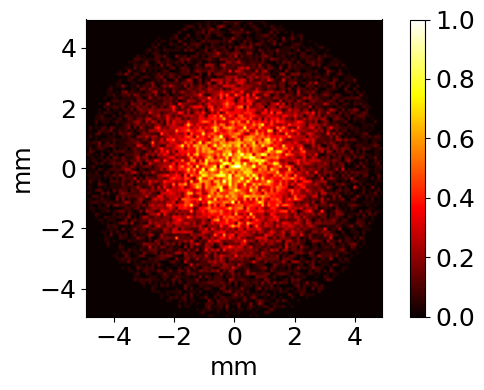

In [373]:
#plot what the focus looks like
# %matplotlib tk
yArr,zArr=interpFunction(xMaxSig)
rArr=np.sqrt(yArr**2+zArr**2)
rMax=5 #mm
yArr=yArr[rArr<rMax]
zArr=zArr[rArr<rMax]
image,yBins,zBins=np.histogram2d(yArr,zArr,bins=100)
print(int(image.sum()),image.max()) 
image=image/image.max()     

yMin=yBins[0]+(yBins[1]-yBins[0])/2
yMax=yBins[-1]-(yBins[1]-yBins[0])/2
zMin=zBins[0]+(zBins[1]-zBins[0])/2
zMax=zBins[-1]-(zBins[1]-zBins[0])/2
plt.figure(dpi=100)
plt.imshow(image,extent=[zMin,zMax,yMin,yMax],cmap='hot')#,interpolation='bicubic')#,vmin=0.0,vmax=25.6/10.0)
plt.xlabel('mm',fontsize=18)
plt.ylabel('mm',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
bar=plt.colorbar()
bar.ax.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig('focusImage_CircleOfLeastConfusion')
plt.show()


15.364354644467403


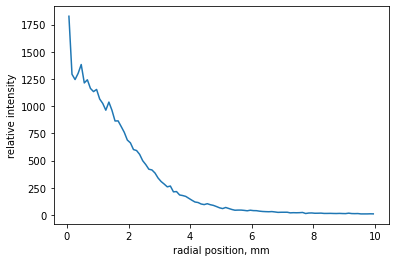

In [374]:
#plot flourescence signal at circle of least confusion
r,signal=get_Floursence_Signal(xMaxSig,maxRadius=10)

rLeastConfuse=circleRadius(xMaxSig)
print(rLeastConfuse)
# plt.figure(dpi=150)
plt.plot(r,signal)
plt.xlabel('radial position, mm')
plt.ylabel('relative intensity')

# plt.axvline(x=rLeastConfuse,c='black',linestyle=':')
# plt.savefig("focusIntensity_CircleOfLeastConfusion")
plt.show()


# Analyze by voigt fit

### helper functions for voigt fitting

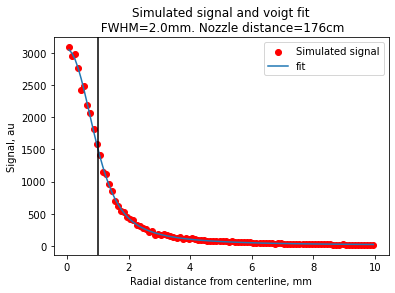

In [375]:
from scipy.special import voigt_profile
from scipy.optimize import curve_fit,differential_evolution
@np.vectorize
def voigt(r,a,b,sigma,gamma):
  #be very cautious about FWHM vs HWHM here for gamma. gamma for scipy is HWHM per the docs
  assert r>=0
  v0=voigt_profile(0,sigma,gamma)
  v=voigt_profile(r,sigma,gamma)/v0
  v=a*v+b
  return v

def fit_Signal_At_x(x,binNum=100,maxRadius=np.inf):
  r,signal=get_Floursence_Signal(x,binNum=binNum,maxRadius=maxRadius)
  guess=[signal.max(),signal.min(),1.0,1.0]
  bounds=[(0.0),(np.inf)]
  params=curve_fit(voigt,r,signal,p0=guess,bounds=bounds)[0]
  return params
def get_FWHM_At_x(x,binNum=100,maxRadius=np.inf):
  #be very cautious about FWHM vs HWHM here for gamma
  params=fit_Signal_At_x(x,maxRadius=maxRadius)
  sigma=params[2]
  gamma=params[3]
  fL=2*gamma
  fG=2*sigma*np.sqrt(2*np.log(2)) #np.log is natural logarithm 
  FWHM=.5346*fL+np.sqrt(.2166*fL**2 + fG**2)
  return FWHM
def plot_Fit_At_x(x,binNum=100,maxRadius=np.inf):
  r,signal=get_Floursence_Signal(x,binNum=binNum,maxRadius=maxRadius)
  FWHM=get_FWHM_At_x(x,binNum=binNum,maxRadius=maxRadius)
  params=fit_Signal_At_x(x,binNum=binNum,maxRadius=maxRadius)
  # print('fwhm:',FWHM,'num particles:', np.sum(signal))#,voigt(FWHM/2,*params)/voigt(0,*params))
  plt.title('Simulated signal and voigt fit\n FWHM='+str(np.round(FWHM,1))+'mm. Nozzle distance='+str(int(1e2*x))+'cm')
  plt.scatter(r,signal,c='red',label='Simulated signal')
  plt.plot(r,voigt(r,*params),label='fit')
  plt.axvline(x=FWHM/2,c='black')
  plt.xlabel('Radial distance from centerline, mm')
  plt.ylabel('Signal, au')
  plt.legend()
  plt.show()
plot_Fit_At_x(1.76,binNum=100,maxRadius=10)

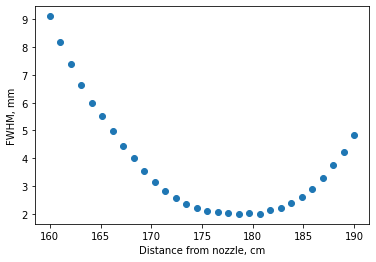

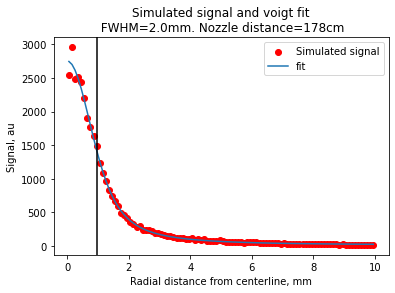

atom in 1 cm circle at min fwhm 30733


In [376]:
import multiprocess as mp
xFWHMArr=np.linspace(1.6,1.9,30)
with mp.Pool(10) as pool:
    FWHMArr=np.asarray(pool.map(get_FWHM_At_x,xFWHMArr))
FWHMxMin=xFWHMArr[np.argmin(FWHMArr)]

plt.scatter(1e2*xFWHMArr,FWHMArr)
plt.xlabel('Distance from nozzle, cm')
plt.ylabel('FWHM, mm')
plt.show()

rMax=10
plot_Fit_At_x(FWHMxMin,maxRadius=rMax)
print('atom in 1 cm circle at min fwhm',atomsInCircle(FWHMxMin,maxRadius=rMax))

# analyze by fit to Voigt CDF

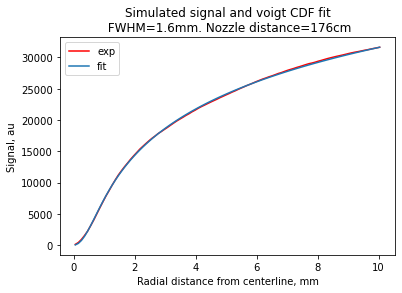

4.04854205485336

In [377]:
@np.vectorize
def voigt_CDF(r,rMax,numParticles,b,sigma,gamma):
  rIntPath=np.linspace(0,r,100)
  CDF=np.trapz(voigt(rIntPath,1,b,sigma,gamma)*rIntPath,x=rIntPath)
  r0IntPath=np.linspace(0,rMax,100)
  CDF0=np.trapz(voigt(r0IntPath,1,b,sigma,gamma)*r0IntPath,x=r0IntPath)
  return numParticles*CDF/CDF0
# voigt_CDF=np.vectorize(voigt_CDF)
def fit_Voigt_CDF(x,return_FitHelpers=False,maxRadius=np.inf,vTMax=np.inf):
  yArr,zArr=interpFunction(x,maxRadius=maxRadius)
  rArr=np.sqrt(yArr**2+zArr**2)
  particleHist,rBins=np.histogram(rArr,bins=100)
  dr=rBins[1]-rBins[0]
  rPosArr=np.linspace(0,len(particleHist)*dr,len(particleHist))+dr/2
  CDF=np.cumsum(particleHist)
  voigt_CDF_Fit_Func=lambda r,sigma,gamma: voigt_CDF(r,rPosArr.max(),CDF.max(),0,sigma,gamma)
  bounds=[0,np.inf]
  guess=[1.0,1.0] #sigma,gamma
  params=curve_fit(voigt_CDF_Fit_Func,rPosArr,CDF,p0=guess,bounds=bounds)[0] #[sigma, gamma]
  if return_FitHelpers==True:
      return params,rPosArr,CDF,voigt_CDF_Fit_Func
  else:
    return params
def calculate_FWHM_From_Gamma_And_Sigma(sigma,gamma):
    assert gamma>=0 and sigma>=0
    fL=2*gamma
    fG=2*sigma*np.sqrt(2*np.log(2)) #np.log is natural logarithm
    FWHM=.5346*fL+np.sqrt(.2166*fL**2 + fG**2)
    return FWHM
def get_FWHM_At_x_From_CDF(x,maxRadius=maxRadius,vTMax=vTMax):
  #be very cautious about FWHM vs HWHM here for gamma
    try:
        sigma,gamma=fit_Voigt_CDF(x,maxRadius=maxRadius,vTMax=vTMax)
    except:
        sigma,gamma=np.nan,np.nan
    return calculate_FWHM_From_Gamma_And_Sigma(sigma,gamma)
def plot_Voigt_CDF_Fit(x,maxRadius=np.inf,vTMax=np.inf):
  params,rPosArr,CDF,fitFunc=fit_Voigt_CDF(x,return_FitHelpers=True,maxRadius=maxRadius,vTMax=vTMax)
  sigma,gamma=params
  FWHM=calculate_FWHM_From_Gamma_And_Sigma(sigma,gamma)
  plt.title('Simulated signal and voigt CDF fit\n FWHM='+str(np.round(FWHM,1))+'mm. Nozzle distance='+str(int(1e2*x))+'cm')
  plt.plot(rPosArr,CDF,label='exp',c='r')
  plt.plot(rPosArr,fitFunc(rPosArr,*params),label='fit')
  plt.legend()
  plt.xlabel('Radial distance from centerline, mm')
  plt.ylabel('Signal, au')
  plt.show()
maxRadius=10
vTMax=30
plot_Voigt_CDF_Fit(1.76,maxRadius=maxRadius,vTMax=vTMax)
get_FWHM_At_x_From_CDF(xMaxSig,maxRadius=maxRadius,vTMax=vTMax)
                    

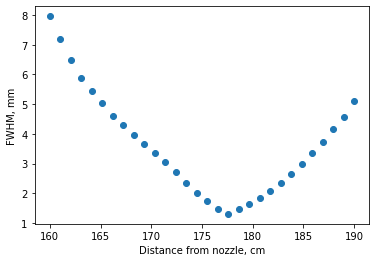

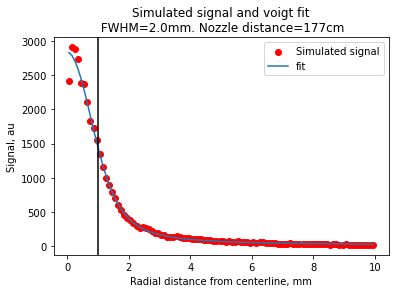

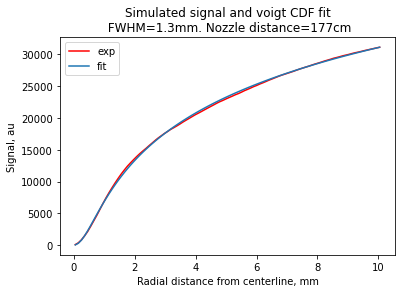

atom in 1 cm circle at min fwhm 31111


In [378]:
import multiprocess as mp
xFWHMArr=np.linspace(1.6,1.9,30)
rMax=10
with mp.Pool(10) as pool:
    wrapper=lambda x:get_FWHM_At_x_From_CDF(x,maxRadius=rMax)
    FWHMArr=np.asarray(pool.map(wrapper,xFWHMArr))
FWHMxMin=xFWHMArr[np.argmin(FWHMArr)]

plt.scatter(1e2*xFWHMArr,FWHMArr)
plt.xlabel('Distance from nozzle, cm')
plt.ylabel('FWHM, mm')
plt.show()
#2.3, 177

plot_Fit_At_x(FWHMxMin,maxRadius=rMax)
plot_Voigt_CDF_Fit(FWHMxMin,maxRadius=rMax)
print('atom in 1 cm circle at min fwhm',atomsInCircle(FWHMxMin,maxRadius=rMax))

### analysis of velocity(spectral) distribution

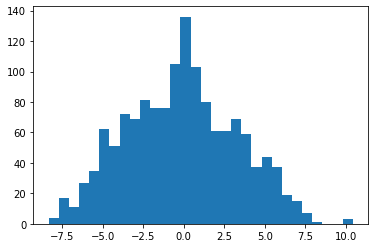

In [379]:
yArr,zArr,pArr=interpFunction(FWHMxMin,returnP=True)

yCoord=1.0 #mm
boxWidth=1. #mm
waist=1.0 #mm
particlesIndices=np.logical_and(yArr<yCoord+boxWidth/2,yArr>yCoord-boxWidth/2)
particlesIndices=np.logical_and(particlesIndices,zArr<waist/2)
particlesIndices=np.logical_and(particlesIndices,zArr>-waist/2)
yArr=yArr[particlesIndices]
zArr=zArr[particlesIndices]
pArr=pArr[particlesIndices]
plt.hist(pArr[:,2],bins=30)
plt.show()


### fit gaussian profile to signal

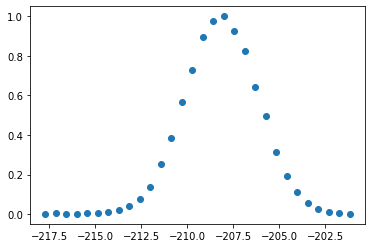

In [380]:
yArr,zArr,pArr=interpFunction(FWHMxMin,returnP=True,maxRadius=5)
pArr=pArr[pArr[:,0]<-195]

signal,binEdges=np.histogram(pArr[:,0],bins=30)
vArr=binEdges[:-1]+(binEdges[-1]-binEdges[-2])/2 #velocity, m/s
signal=signal/signal.max()
plt.scatter(vArr,signal)
plt.show()

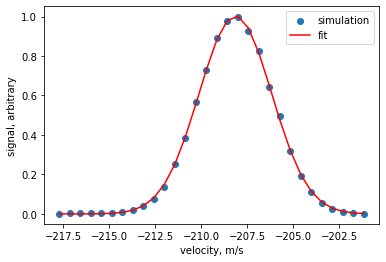

T, mk 3.289789191782842


In [381]:
import scipy.optimize as spo
kb=1.381e-23
m=1.16238e-26
def gauss(v,v0,a,b,T):
    sigma=np.sqrt(kb*T/m)
    return a*np.exp(-.5*((v-v0)/sigma)**2)+b
bounds=[(-220.0,0.0,0.0,0.0),(-195.0,np.inf,np.inf,np.inf)]
guess=[-210,1.0,0.0,1e-3]
params=spo.curve_fit(gauss,vArr,signal,bounds=bounds,p0=guess)[0]
# params=guess
plt.scatter(vArr,signal,label='simulation')
plt.plot(vArr,gauss(vArr,*params),c='r',label='fit')
plt.ylabel('signal, arbitrary')
plt.xlabel('velocity, m/s')
plt.legend()
plt.show()
print('T, mk',1e3*params[-1]) #3.0

# Fit now by sending a flat top beam vertically

In [382]:
@np.vectorize
def voigt_Probe(y,a,b,sigma,gamma):
    #be very cautious about FWHM vs HWHM here for gamma. gamma for scipy is HWHM per the docs
    v0=voigt_profile(0,sigma,gamma)
    v=voigt_profile(y,sigma,gamma)/v0
    v=a*v+b
    return v

def fit_Signal_At_x__Probe(x,beamDiam,binNum=100,maxRadius=np.inf,Plot=False):
    yArr,zArr=interpFunction(x)
    #scan in the y direction
    yVals=yArr[np.abs(zArr)<beamDiam/2]
    yVals=yVals[np.abs(yVals)<maxRadius]
    signal,yBins=np.histogram(yVals,bins=binNum)
    dy=yBins[1]-yBins[0]
    yPosArr=yBins[:-1]+dy/2
    guess=[signal.max(),signal.min(),1.0,1.0] # [...,sigma,gamma]
    bounds=[(0.0),(np.inf)]
    params=curve_fit(voigt_Probe,yPosArr,signal,p0=guess,bounds=bounds)[0]
    if Plot==True:
        plt.scatter(yPosArr,signal)
        plt.plot(yPosArr,voigt_Probe(yPosArr,*params),c='r')
        plt.show()
    return params[-2:]
def get_FWHM_At_X__Probe(x,beamDiam,maxRadius=np.inf):
    sigma,gamma=fit_Signal_At_x__Probe(x,beamDiam,maxRadius=maxRadius)
    return calculate_FWHM_From_Gamma_And_Sigma(sigma,gamma)
def plot_Probe_Signal(x,beamDiam,maxRadius=np.inf):
    fit_Signal_At_x__Probe(x,beamDiam,maxRadius=maxRadius,Plot=True)

xScan=1.82 #meter
beamDiam=1 #mm
rMax=10 #mm
# sigma,gamma=fit_Signal_At_x__Probe(xScan,1,maxRadius=10)
# calculate_FWHM_From_Gamma_And_Sigma(sigma,gamma)

In [383]:
beamDiamArr=np.linspace(.1,10)
vals=[get_FWHM_At_X__Probe(xScan,beamDiam,maxRadius=10) for beamDiam in beamDiamArr]

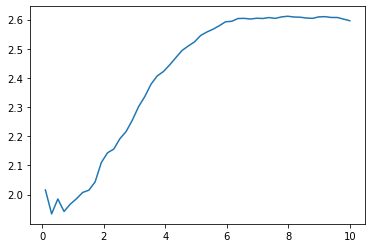

In [384]:
plt.plot(beamDiamArr,vals)

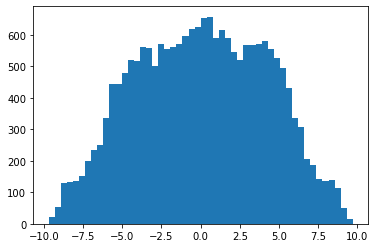

(19850,)

In [385]:
yArr,zArr,pArr=interpFunction(1.82,returnP=True,maxRadius=5)
pzArr=pArr[:,1]#[np.logical_and(np.logical_and(yArr>0,yArr<1),np.logical_and(zArr<2,zArr>1))]
plt.hist(pzArr,bins=50)
plt.show()
pzArr.shape